In [1]:
%%bash
git clone -q https://github.com/Kaggle/kaggle-environments.git
cd kaggle-environments && pip3 install -qq . && cd ..

apt-get -qq update
apt-get -qq install libsdl2-gfx-dev libsdl2-ttf-dev > /dev/null

GRF_VER=v2.8
GRF_PATH=football/third_party/gfootball_engine/lib
GRF_URL=https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_${GRF_VER}.so
git clone -q -b ${GRF_VER} https://github.com/google-research/football.git
mkdir -p ${GRF_PATH}
wget -q ${GRF_URL} -O ${GRF_PATH}/prebuilt_gameplayfootball.so

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [2]:
#from gfootball.env.football_env import FootballEnv
from kaggle_environments import make
from gfootball.env.config import Config
import gfootball.env as football_env

#import dqn libraries
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import numpy as np
import pandas as pd
import itertools
import utils
import random
from collections import deque
import matplotlib.pyplot as plt
#from utils import plot_learning_curve
#import env 
import gym
import gfootball 
import math

#env_name = "GFootballBase-v0"
#print(env_name)

In [3]:
%%writefile football/gfootball/scenarios/my_academy.py
from . import *


def build_scenario(builder):
  builder.config().game_duration = 400
  builder.config().deterministic = False
  builder.config().offsides = False
  builder.config().end_episode_on_score = True
  builder.config().end_episode_on_out_of_play = True
  builder.config().end_episode_on_possession_change = True
  builder.SetBallPosition(0.02, 0.0)

  builder.SetTeam(Team.e_Left)
  builder.AddPlayer(-1.0, 0.0, e_PlayerRole_GK)
  builder.AddPlayer(0.0, 0.0, e_PlayerRole_CB)

  builder.SetTeam(Team.e_Right)
  #builder.AddPlayer(-1.0, 0.0, e_PlayerRole_GK)
 

Writing football/gfootball/scenarios/my_academy.py


In [4]:
%%bash
cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install -qq . && cd ..
rm -rf football kaggle-environments

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [5]:
env = football_env.create_environment(env_name ='my_academy',render=False,representation='simple115v2')  #List with the 115 states 
observation = env.reset()
new_observation,reward,done,info = env.step(5)
print("PRIN",new_observation)
new_observation,reward,done,info = env.step(7)
print("META",new_observation)
env.reset()

MPIKA
MPIKA
MPIKA
MPIKA
MPIKA


array([-1.0110294 , -0.        ,  0.        , -0.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        ,  0.        , -0.        ,  0.        ,
       -0.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        ,  1.0110294 ,
       -0.4268325 , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -0.        ,  0.        , -1.        , -1.  

In [6]:
class DeepQNetwork(nn.Module):
  def __init__(self,lr,input_dims,fc1_dims,fc2_dims,fc3_dims,n_actions):
    super(DeepQNetwork,self).__init__()
   # self.lr=lr
    self.input_dims=input_dims
    self.fc1_dims=fc1_dims
    self.fc2_dims=fc2_dims
    self.fc3_dims=fc3_dims
    self.n_actions=n_actions
    
    self.fc1=nn.Linear(*self.input_dims,self.fc1_dims) #pass list of observations as input
    self.fc2=nn.Linear(self.fc1_dims,self.fc2_dims)
    self.fc3=nn.Linear(self.fc2_dims,self.fc3_dims)
    self.fc3=nn.Linear(self.fc3_dims,self.n_actions) #output number action

    self.optimizer = optim.Adam(self.parameters(),lr=lr)
    self.loss=nn.MSELoss()
    self.device =T.device('cuda:0' if T.cuda.is_available() else 'cpu' )
    self.to(self.device)

  def forward(self,state):
   
    x=F.relu(self.fc1(state))
    x=F.relu(self.fc2(x))
    actions=self.fc3(x)
      
    return actions


In [7]:
class All_prints():
  
  def __init___(self,step):
    self.step=step
    #self.RewBuffer = RewBuffer
    self.reward=reward

  def printstats(self,step,rew_list,eps_reward,epsilon):  #Kaleitai otan ginei done , diladi otan teleiosei ena paixnidi
    self.step=step
    self.rew_list=rew_list
    self.eps_reward=eps_reward
    self.epsilon=epsilon
    print("-->Episode:",i%3000 + 1,"\t","Episode Reward:",eps_reward,"\t Epsilon",agent.epsilon,"<--")
    #print("Step",step)
    print("lista apo rewards mexri tora" ,self.rew_list)
    print("Avg reward", np.mean(self.rew_list))
    print("---------------------------------------------------")

  def print_who_scored(self, reward):
    self.reward=reward
    if(self.reward==1):
      print("our team scored !!!")
    elif(self.reward ==-1):
      print("opponent team scored")
    
    
 
  def rew_graph(self,rew_list,num_of_eps):
      self.rew_list=rew_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.rew_list)
      plt.xlabel('Episode')
      plt.ylabel('Rewards')
      plt.grid(True)
      plt.show()


  def score_graph(self,score_list,num_of_eps):
      self.score_list=score_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.score_list)
      plt.xlabel('Episode')
      plt.ylabel('Score')
      plt.grid(True)
      plt.show()

In [8]:
class Agent():
  def __init__(self,gamma,epsilon, lr , input_dims , batch_size ,n_actions, max_mem_size = 40000  , eps_end=0.01 , eps_dec = 5e-4):
    self.gamma=gamma
    self.epsilon =epsilon
    self.lr=lr
    self.eps_min=eps_end
    self.eps_dec=eps_dec
   
    self.action_space =[i for i in range(n_actions)]
    self.mem_size = max_mem_size
    self.batch_size = batch_size
    self.n_actions=n_actions
    self.mem_cntr =0 # keep track of the position of first available memory 

    self.Q_eval = DeepQNetwork(self.lr,n_actions=n_actions,input_dims= input_dims, fc1_dims=600, fc2_dims=600 , fc3_dims=600)

    self.state_memory = np.zeros((self.mem_size,*input_dims),dtype =np.float32)
    self.new_state_memory= np.zeros((self.mem_size , *input_dims),dtype=np.float32)

    self.action_memory=np.zeros(self.mem_size , dtype=np.int32) #discrete actions (19)
    self.reward_memory=np.zeros(self.mem_size,dtype= np.float32)
    self.terminal_memory= np.zeros(self.mem_size,dtype=bool)


  def store_transition(self,state,action,reward,new_state , done ):
    index = self.mem_cntr% self.mem_size

    self.state_memory[index]= state
    self.new_state_memory[index]= new_state
    self.reward_memory[index]= reward
    self.action_memory[index]= action  #which action is taken 
    self.terminal_memory[index]= done

    self.mem_cntr +=1
    

  def choose_action(self,observation):
    if np.random.random()> self.epsilon:
      
      state =T.tensor([observation]).to(self.Q_eval.device) #turn observation to tensor and send it to device for computations
      action_list = self.Q_eval.forward(state) #returns the values of each action
      action = T.argmax(action_list).item()
      #print("exploit:",action)
    else:     #
      
      action = np.random.choice(self.action_space)
      #print("explore:",action)
    return action

  def learn(self):    #fill batch size then learn 
    if self.mem_cntr < self.batch_size :
      return
    
    
    self.Q_eval.optimizer.zero_grad()

    #calculate the position of max memory / extract subset of max memories
    max_mem =min(self.mem_cntr , self.mem_size)
    for i in range(self.mem_size//self.batch_size):
      #batch=np.random.choice(max_mem,self.batch_size,replace=False) #We dont keep selecting the same memories more than once
     
      batch = np.random.permutation(max_mem)[:self.batch_size]
      #mem = np.array(exp_buffer)[perm_batch]

      #batch=np.random.choice(max_mem,self.batch_size,replace=False)
      batch_index = np.arange(self.batch_size , dtype=np.int32)

      state_batch=T.tensor(self.state_memory[batch]).to(self.Q_eval.device) #make numpy array a pytorch tensor
      new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
      reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
      terminal_batch= T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

      action_batch = self.action_memory[batch] 
    
      q_eval = self.Q_eval.forward(state_batch)[batch_index,action_batch] #EXEI THEMA
      q_next = self.Q_eval.forward(new_state_batch)

      q_next[terminal_batch] = 0.0
      q_target = reward_batch +self.gamma * T.max(q_next,dim=1)[0] #max value of next state

      loss = self.Q_eval.loss(q_target,q_eval).to(self.Q_eval.device)
      loss.backward()
      self.Q_eval.optimizer.step()

      self.epsilon = self.epsilon - self.eps_dec if (self.epsilon > self.eps_min)  else self.eps_min
      

shout entos periohis Ball Position 0.66351295 -0.012569426 0.108891085 episode 0 step= 98
goal episode 0 step= 109
---Avg reward last: -2.401509414597342 Avg score last 1.0 Avg steps 110.0 episode= 0 ---
shout entos periohis Ball Position 0.66965896 0.030239698 0.109941214 episode 1 step= 101
goal episode 1 step= 113
shout entos periohis Ball Position 0.88040626 0.00067246915 0.12784548 episode 2 step= 137
goal episode 2 step= 143
shout entos periohis Ball Position 0.7089437 -0.058932785 0.110269725 episode 3 step= 109
goal episode 3 step= 119
shout entos periohis Ball Position 0.7880109 0.09671088 0.110050425 episode 4 step= 119
ball is out -10 episode 4 Ball Position 1.0108361 0.05233012 0.17227572 step= 128
shout entos periohis Ball Position 0.8115781 0.21025577 0.11076024 episode 5 step= 127
goal episode 5 step= 139
shout entos periohis Ball Position 0.67705643 -0.11112292 0.11642915 episode 6 step= 97
goal episode 6 step= 109
shout entos periohis Ball Position 0.6635279 -0.0183874

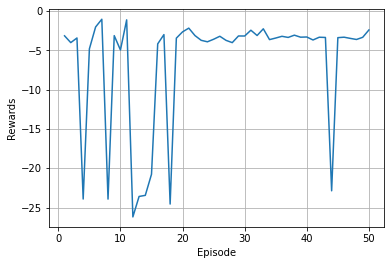

shout entos periohis Ball Position 0.6654905 -0.021926135 0.117658295 episode 51 step= 109
goal episode 51 step= 123
shout entos periohis Ball Position 0.6585067 0.042081658 0.12782247 episode 52 step= 95
goal episode 52 step= 108
shout entos periohis Ball Position 0.66091007 -0.034833748 0.12559806 episode 53 step= 103
goal episode 53 step= 115
shout entos periohis Ball Position 0.66133 0.038011156 0.11002204 episode 54 step= 100
goal episode 54 step= 111
shout entos periohis Ball Position 0.66049206 -0.0023472505 0.12835813 episode 55 step= 100
goal episode 55 step= 111
shout entos periohis Ball Position 0.66519016 0.009561499 0.11813846 episode 56 step= 104
goal episode 56 step= 114
shout entos periohis Ball Position 0.6643678 -0.009786075 0.107446365 episode 57 step= 106
goal episode 57 step= 118
shout entos periohis Ball Position 0.6618946 0.07317381 0.12694731 episode 58 step= 102
ball is out -10 episode 58 Ball Position 0.9927882 0.051965635 0.10935552 step= 114
shout entos peri

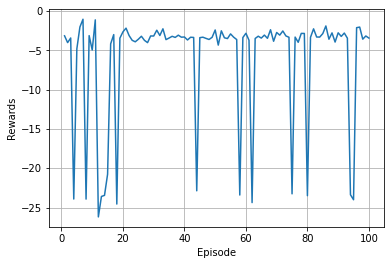

shout entos periohis Ball Position 0.66071624 0.020685153 0.11476583 episode 101 step= 91
goal episode 101 step= 103
shout entos periohis Ball Position 0.66796327 -0.004536112 0.10843636 episode 102 step= 101


In [ ]:
#TODO: NA BGALO TON PAIKTI

#if __name__ == '__main__':
#env = football_env.create_environment(env_name ='11_vs_11_easy_stochastic',render=False,representation='simple115')  #List with the 115 states 
env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115v2')  #List with the 115 states 
#env = gym.make("GFootball-11_vs_11_kaggle-simple115v2-v0") #List with the 115 states
#env = football_env.create_environment(env_name ='academy_single_goal_versus_lazy',render=False,representation='simple115')
#env = football_env.create_environment(env_name ='academy_pass_and_shoot_with_keeper',render=False,representation='simple115')
#env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115')  #List with the 115 states 

#CUSTOMIZE ACTION LIST AND OBSERVATIONS
Action_list=[4,5,6,12]

#Create Objects

agent = Agent(gamma=0.99,epsilon=1.0 ,batch_size = 264 ,lr=0.00015 ,input_dims= [115], n_actions = len(Action_list) )# batch = best 256
all_prints = All_prints()
#cus_rew =Custom_Rewards()

scores,ep_history =[],[]

steps=0
terminal =0
episode =0
shout =0


num_of_eps = 1000
eps_rew=0
rew_list =[]
score_list = []
step_list =[]
for i in range(num_of_eps) : 
  score =0 
  done=False 
  observation =env.reset()
  act =0 #first action will be to move right 
  shout=0 #mporei na kanei shout 1 fora se kathe ep
  while not done:

    #CUSTOMIZE ACTIONS HERE 
    #An einai i mpala sto 0.5 kai exo katoxi kane shout diladi action 12
    
    #print("------------")
    #print("Ball X-Y-Z Axis",observation[88],observation[89],observation[90],"||","direct",observation[91],observation[92],observation[93],"Katoxi",observation[95],observation[96])
    #print("Player X-Axis Y-Axis",observation[2],observation[3] ,"episode",i)
    #print("------------")

   
     
      
 
    if(act ==0 ):
      
      # print("action 5",Action_list[action])
      new_observation,reward,done,info = env.step(5)
      act=1
    #print("Sto Else",observation[94],observation[95],observation[96])
    

    #CUSTOM ACTIONS
    action = agent.choose_action(observation) # from 1-4 which is index to action list

    while((observation[2]<0.65)  and (Action_list[action]==12)): #Den kanei shout ektos periohis
      action = agent.choose_action(observation)


    if(shout==0):   #ama kanei shout na min kanei tipota meta 
      new_observation,reward,done,info = env.step(Action_list[action])
      
      if(Action_list[action]==12):
        #print("EKANE SHOUT")
        shout=1
    else:
      #print("MPIKE STO ELSE")
      new_observation,reward,done,info = env.step(0)
      action=0 #Ta parakato if den pianoun to Action_list[action]=12 alla gia Action_list[action]=4

   
    
    
    #CUSTOM REWARDS
    if(done ==1 and reward !=1): #if ball is out ,loses -2
      reward = reward -10
      print("ball is out -10","episode",i,"Ball Position",observation[88],observation[89],observation[90],"step=",steps)
    if(done ==1 and reward !=1 and observation[96]==1):
      print("STEAL")
    if(reward==1 and  done ==1): #if agent scores , wins +5
      print("goal","episode",i,"step=",steps)
      reward = 10

    if((observation[2]<0.5) and (observation[95] == 1) and (Action_list[action]==12)): #an shoutarei prin th megali perioxh -2
      
      reward= reward -200
      done=1
      print("shout ektos periohis","episode",i,"step=",steps)
      
    if((observation[2]>0.5) and (observation[95] == 1) and (Action_list[action]==12)): #an shoutarei mesa ti megali periohi +0.1
      #reward= reward +0.1
      print("shout entos periohis Ball Position",observation[88],observation[89],observation[90],"episode",i,"step=",steps)
      
    
    reward = reward - ( math.sqrt( ((0.935 - observation[2])**2) + (0 -observation[3])**2 ) *0.2) #oso pio makria einai toso perissotero xanei
    #print("Den exo mpala",Action_list[action])
    #print("DEN EXO MPALA",Action_list[action],action)

    #custom reward here
 
    
   
    score= +reward

    #for prints
    eps_rew+=reward
    #all_prints.print_who_scored(reward)
    

    agent.store_transition(observation,action,reward,new_observation,done)
    agent.learn()
    observation = new_observation

    scores.append(score)
    ep_history.append(agent.epsilon)

    avg_score= np.mean(scores)


    steps=steps+1
    
#---- BE CAREFUL OF THE WHILE !!! HERE IS EPIDOSE ENDING--------
  #print("Reward",eps_rew,"Episode",i,"Steps" , steps)
  step_list.append(steps)
  steps=0

  val = info.values()
  list_val=list(val)
  score_list.append(list_val)
  
  #terminate if 500 episodes are correct 
  if(eps_rew == 1 ):
    terminal= terminal +1
    if(terminal == 500):
      print("500 Episodes with goal")
      break
  else:
      terminal =0 
  episode = episode +1 
  

  rew_list.append(eps_rew)

# PRINTS
  if (i % 10)== 0 :
      print("---Avg reward last:", np.mean(rew_list[-10:]),"Avg score last",np.mean(score_list[-10:]),"Avg steps",np.mean(step_list[-10:]),"episode=",i,"---")
      #print(score_list)

  if (((i % 1000)== 0) and i!=0) :
      all_prints.score_graph(score_list[-1000:],1000)# graph the last 1000 episodes
  if(((i%50)==0) and i!=0):
    all_prints.rew_graph(rew_list[-i:],i)
     
  
  #EPISODE PRINTS
  #all_prints.printstats(i,rew_list,eps_rew,agent.epsilon)
  
  eps_rew=0



print("Avg score last:", np.mean(rew_list[-10:]),"Avg score",np.mean(score_list),"Avg steps",np.mean(step_list[-10:]),"episode=",i)
all_prints.score_graph(score_list[-1000:],1000)# graph the last 1000 episodes
      
#all_prints.score_graph(score_list,i+1)#i = num_of_eps
#print("\n ")
#all_prints.rew_graph(rew_list,i+1)


In [ ]:
#plot step_list plt.plot(step_list)

In [ ]:
class Custom_Rewards():
  #def __init__(self):
    #self.obs=obs    
    #self.action=action
    #self.reward =reward
  def custom_rew(self,obs,action,reward,new_obs):
    
    self.obs=obs
    self.action = action
    self.reward = reward
    self.new_obs=new_obs
    
    
#if the next action is shooting the ball, the reward will gain 0.2 point ||
#an exo ti mpala kai einai se apostasi x > 0.5 sto gipedo kai exei kanei shout einai kalo    
    if(self.obs[95] == 1 and self.obs[88] > 0.6 and self.action == 12):
      self.reward += 0.02
      #print("EKANE SHOUT MPROSTA APO TO KENTRO ,+0.1")
      return self.reward

    #An kanei shout piso apo to kentro na xanei ligo
    elif(self.obs[95]==1 and self.obs[88] < 0 and self.action == 12):
      self.reward -= 0.02
      #print("EKANE SHOUT PISO APO TO KENTRO, -0.05")
      return self.reward

# if we steal the ball, the reward will gain 0.05 points
    elif self.obs[96] == 1 and self.new_obs[95] == 1:  #obs[96] ball owner right team / obs[95] ball owner left team
        self.reward += 0.05
        #print("PHRE THN MPALA APO TON ANTIPALO , +0.05")
        return self.reward
#if we lose the ball, the reward will lose 0.05 points
    elif self.obs[95] == 1 and self.new_obs[96] == 1:
        self.reward -=0.02
        #print("PHRE THN MPALA O ANTIPALOS , -0.02")
        return self.reward
    else:
      return self.reward


#TODO: if active player far from the ball, the reward will lose by the moving distance

In [ ]:
#print(score_list or reward_list)

In [ ]:

"""print(observation)
new_observation,reward,done,info = env.step(4)
print(new_observation)"""

In [ ]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

In [ ]:
"""env = football_env.create_environment(env_name ='academy_single_goal_versus_lazy',render=False,representation='simple115')
observation =env.reset()
new_observation,reward,done,info = env.step(action)
val=info.values()
print(val)
list_val=list(val)
list_val"""